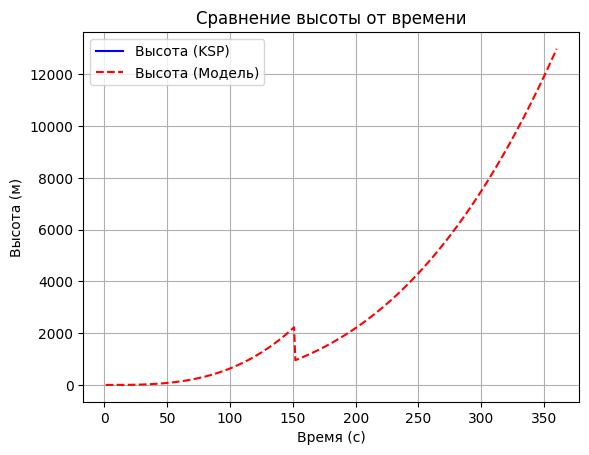

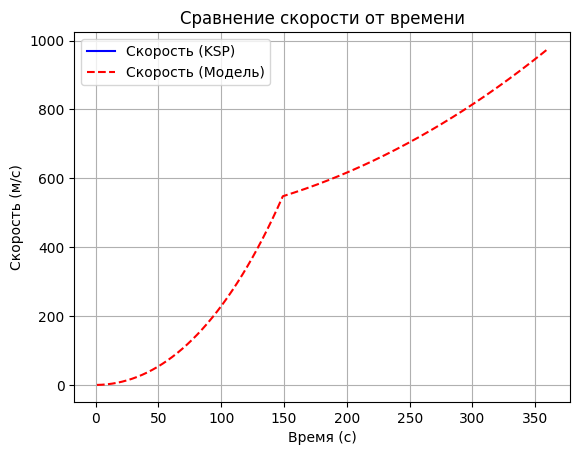

ValueError: x and y must have same first dimension, but have shapes (0,) and (15,)

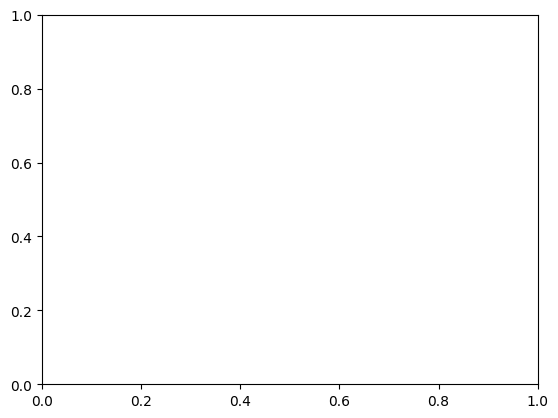

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Чтение данных из файла
import sys

try:
    df = pd.read_csv('Data.csv', sep=';')
except FileNotFoundError:
    df = pd.DataFrame(columns=["Time", "Velocity", "AltitudeFromTerrain"]) 
    
# Извлечение данных из таблицы
Time = df['Time']
Velocity = df['Velocity']
Altitude = df['AltitudeFromTerrain']

# Ограничиваем данные до 360 секунд
Time_filtered = Time[Time <= 360]
Velocity_filtered = Velocity[:len(Time_filtered)]
Altitude_filtered = Altitude[:len(Time_filtered)]


# Вычисление ускорения от скорости
Acceleration = np.diff(Velocity_filtered) / np.diff(Time_filtered)
Acceleration = np.insert(Acceleration, 0, 0)  # Добавляем 0 для совместимости

# Для сглаживания ускорения применяем скользящее среднее
Acceleration_smooth = np.convolve(Acceleration, np.ones(15) / 15, mode='same')
# Математическая модель
G = 6.6743 * 10**(-11)
Mz = 5.974 * 10**24
m0 = 571585
n1 = 1900
n2 = 20
u = 3000
fuel1 = 500265
fuel2 = 20830
msuh1 = 38247
msuh2 = 2243
m1 = msuh1 + fuel1
m2 = msuh2 + fuel2
Mgraph = []
V = []
v0 = 0

# Функция для расчёта тяготы
def Ftyag(m):
    return G * ((Mz * m) / (6400000)**2)

# Моделирование до 360 секунд
for t in range(1, 150):  # Период с ускорением n1
    m = m0 - n1 * t
    Mgraph.append(m)
    v1 = (v0 - u * np.log(m / m0) - (G * Mz * np.log(m / m0)) / (6400000**2))
    d = v1 / 1000 * 4
    V.append(d)
    v0 = v1
    if t >= 360:
        break

m0 -= fuel1 + msuh1

for t in range(150, 1095):  # Период с ускорением n2
    m = m0 - n2 * t
    Mgraph.append(m)
    v1 = (v0 - u * np.log(m / m0) - (G * Mz * np.log(m / m0)) / (6400000**2))
    d = v1 / 1000 * 4
    V.append(d)
    v0 = v1
    if t >= 360:
        break

m0 -= fuel2 + msuh2

# Рассчитаем ускорение и высоту на основе модели
Acc = [0] * len(V)
T = np.arange(1, len(V) + 1)
H = [0] * 500

for t in range(len(V)):
    if t < 150:
        Acc[t] = ((u * n1 * t - Ftyag(m1 - (4 * 1120 + 1818) * (t + 1))) / m1) / 80
        H[t + 1] = (Acc[t] * ((t + 1)**2)) / 200
    else:
        Acc[t] = ((u * n2 * t - Ftyag(m2 - 2281 * 2 * (t + 1))) / m2) / 80
        H[t + 1] = (Acc[t] * ((t + 1)**2)) / 200
    if t >= 360:
        break
        
# Построение графиков
plt.plot(Time_filtered, Altitude_filtered, label="Высота (KSP)", color="blue")
plt.plot(T[:len(V)], H[:len(V)], label="Высота (Модель)", color="red", linestyle='--')

plt.title("Сравнение высоты от времени")
plt.xlabel("Время (с)")
plt.ylabel("Высота (м)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Time_filtered, Velocity_filtered, label="Скорость (KSP)", color="blue")
plt.plot(T[:len(V)], V[:len(V)], label="Скорость (Модель)", color="red", linestyle='--')

plt.title("Сравнение скорости от времени")
plt.xlabel("Время (с)")
plt.ylabel("Скорость (м/с)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(Time_filtered, Acceleration_smooth, label="Ускорение (KSP)", color="blue")
plt.plot(T[:len(V)], Acc[:len(V)], label="Ускорение (Модель)", color="red", linestyle='--')

plt.title("Сравнение ускорения от времени")
plt.xlabel("Время (с)")
plt.ylabel("Ускорение (м/с²)")
plt.legend()
plt.grid(True)
plt.show()


![График высоты](graph/высота_ксп.png)
![График скорости](graph/скорость.png)
![График ускорения](graph/ускорение.png)
